In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Bidirectional

En esta sección se realizará un ejercicio de clasificación de canciones en sus respectivos géneros musicales `reggaetón, salsa y ranchera`. ¿Cree que es posible conseguir un modelo capaz de distinguirlos?

In [2]:
df = pd.read_csv('song_lyrics_df.csv')

In [3]:
df.head()

,song_name,lyrics,genre
0,quizas-part-rich-music-dalex-justin-quiles-wis...,Hola (The Avengers)\nQuiero saber tu nombre\nY...,reggaeton
1,no-es-por-aca.txt,Ya me mordí uno\nYo ya no la busco\nDonde se l...,ranchera
2,ojitos-de-miel.txt,De tus labios me muero por un beso\nY de tus o...,ranchera
3,lo-que-va-a-ser-para-uno.txt,No hay que culpar al destino\nPor encontrarnos...,ranchera
4,1406330.txt,"Ya viene amaneciendo\nla luz ya nos alumbra,\n...",ranchera


In [4]:
import textwrap

lyrics = df[df.song_name.str.contains('tqg')].lyrics.iloc[0]
wrapped_lyrics = textwrap.fill(lyrics, width=80)

print(wrapped_lyrics)


La que te dijo que un vacío se llenó con otra persona, te miente Es como tapar
una herida con maquillaje, no se ve, pero se siente Te fuiste diciendo que me
superaste y te conseguiste nueva novia Lo que ella no sabe es que tú todavía me
está' viendo toa' las Historias Bebé, ¿qué fue? No pues, qué muy tragaíto' ¿Qué
haces buscándome el la'o Si sabes que yo, errores, no repito? (papi) Dile a tu
nueva bebé Que, por hombres, no compito Que deje de estar tirando Que, al menos,
yo te tenía bonito Verte con la nueva, me dolió Pero ya estoy puesta pa' lo mío
Lo que vivimos, se me olvidó Y eso es lo que te tiene ofendido Que hasta la vida
me mejoró Por acá, ya no eres bienvenido Vi lo que tu novia me tiró Eso no da ni
rabia, yo me río, yo me río No tengo tiempo pa' lo que no aporte Ya cambié mi
norte Haciendo dinero como deporte Llenando la cuenta, los show', el parking y
el pasaporte Estoy más dura, dicen los reportes Ahora tú quieres volver, se te
nota, mmm, sí Espérame ahí, que yo soy idiota

# 1. Pre-Procesamiento de Texto

El Pre-Procesamiento del texto es de los pasos más improtantes en el NLP. Particularmente, es importante estandarizar el texto, eliminar ruido y caracteres especiales. Es importante eliminar palabras que no tienen un significado.

A continuación, se va a crear una función que permita eliminar tildes, símbolos, números (a menos que sean relevantes) y espacios extra.

Utilizaremos la librería `unicodedata` para eliminar todas las tildes (para entender qué hace, puede consultar [este artículo](https://towardsdatascience.com/difference-between-nfd-nfc-nfkd-and-nfkc-explained-with-python-code-e2631f96ae6c)). Y por medio de la expresión regular `[^a-zA-Z\s]` se eliminará todo lo que sea diferente a una letra o un espacio. 

In [5]:
import re
import unicodedata

def clean_text(text):
    # Elimina tildes
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Vuelve el texto minúscula
    text = text.lower()
    
    # Elimina caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Elimina múltiples espacios
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Se aplica a 
df['lyrics'] = df['lyrics'].apply(clean_text)


In [6]:
genres = df.genre.unique().tolist()

In [7]:
lyrics = df[df.song_name.str.contains('tqg')].lyrics.iloc[0]
wrapped_lyrics = textwrap.fill(lyrics, width=80)

print(wrapped_lyrics)


la que te dijo que un vacio se lleno con otra persona te miente es como tapar
una herida con maquillaje no se ve pero se siente te fuiste diciendo que me
superaste y te conseguiste nueva novia lo que ella no sabe es que tu todavia me
esta viendo toa las historias bebe que fue no pues que muy tragaito que haces
buscandome el lao si sabes que yo errores no repito papi dile a tu nueva bebe
que por hombres no compito que deje de estar tirando que al menos yo te tenia
bonito verte con la nueva me dolio pero ya estoy puesta pa lo mio lo que vivimos
se me olvido y eso es lo que te tiene ofendido que hasta la vida me mejoro por
aca ya no eres bienvenido vi lo que tu novia me tiro eso no da ni rabia yo me
rio yo me rio no tengo tiempo pa lo que no aporte ya cambie mi norte haciendo
dinero como deporte llenando la cuenta los show el parking y el pasaporte estoy
mas dura dicen los reportes ahora tu quieres volver se te nota mmm si esperame
ahi que yo soy idiota se te olvido que estoy en otra y qu

In [8]:
df.head()

,song_name,lyrics,genre
0,quizas-part-rich-music-dalex-justin-quiles-wis...,hola the avengers quiero saber tu nombre y qui...,reggaeton
1,no-es-por-aca.txt,ya me mordi uno yo ya no la busco donde se las...,ranchera
2,ojitos-de-miel.txt,de tus labios me muero por un beso y de tus oj...,ranchera
3,lo-que-va-a-ser-para-uno.txt,no hay que culpar al destino por encontrarnos ...,ranchera
4,1406330.txt,ya viene amaneciendo la luz ya nos alumbra par...,ranchera


In [9]:
# Obtener la columna 'texto' del dataframe
columna_texto = df['lyrics']

# Iterar sobre cada registro y contar las palabras
conteo_palabras = [len(registro.split()) for registro in columna_texto]

# Agregar el conteo de palabras como una nueva columna en el dataframe
df['conteo_palabras'] = conteo_palabras

# Imprimir el dataframe con el conteo de palabras
print(df)

print(df['conteo_palabras'].describe())

                                              song_name  \
0     quizas-part-rich-music-dalex-justin-quiles-wis...   
1                                     no-es-por-aca.txt   
2                                    ojitos-de-miel.txt   
3                          lo-que-va-a-ser-para-uno.txt   
4                                           1406330.txt   
...                                                 ...   
1014                                        el-menu.txt   
1015                  viviendo-el-proceso-part-best.txt   
1016                               el-pajaro-chogui.txt   
1017                                        1141395.txt   
1018                                        1187661.txt   

                                                 lyrics      genre  \
0     hola the avengers quiero saber tu nombre y qui...  reggaeton   
1     ya me mordi uno yo ya no la busco donde se las...   ranchera   
2     de tus labios me muero por un beso y de tus oj...   ranchera   
3     no ha

# 2. Train-Test Split

A continuación se realiza la división en train-val-test, para el entrenamiento del modelo. 
Esta división es importante por varias razones:
1. Es necesario definir el vocabulario sobre el cual se va a entrenar el modelo [train].
2. Es necesario hacer el seguimiento del entrenamiento del modelo en validación para evitar el overfitting [val].
3. Utilizando test se mide el desempeño del modelo en la vida real [test]

In [10]:
# Assuming your dataframe is called 'df'
# Splitting the dataframe into features (X) and target variable (y)
X = df.drop('genre', axis=1)
y = df['genre']

# Obtaining the total number of rows in the dataframe
total_rows = df.shape[0]

# Generating random indices for the train and test sets
train_indices = np.random.choice(total_rows, int(0.7 * total_rows), replace=False)
test_indices = np.setdiff1d(np.arange(total_rows), train_indices)

### Realice la Partición en Train (70) y Test (30)

train_df, test_df = train_test_split(df,test_size=0.3,random_state=42)

### Particione el dataset de Train en Train (70) y validación (30)
train_df, val_df = train_test_split(train_df,test_size=0.3,random_state=42)

###

# 3. Vocabulary and Sequences

Para que el modelo pueda entender las canciones, debe tokenizarse para convertir las palabras en números. Para esto se utilizará el [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) cuya responsabilidad es convertir una secuencia de texto (la canción) en una secuencia de números. 

Se debe definir el número máximo de palabras que aceptaremos por canción `max_length` y el tamaño del vocabulario `max_words`. 

Estos números no pueden ser aleatorios, pero se deben definir inicialmente para poder utilizarlos. Defina `max_words = 5000`. 

A continuación, utilize [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) y utilice el método `fit_on_texts` para aprender el vocabulario de las canciones que se encuentran en train. 

In [11]:
###
tokenizer = Tokenizer(
    num_words=384)
tokenizer.fit_on_texts(train_df.lyrics)
###
word_index = tokenizer.word_index

El parámetro `num_words` determina la cantidad de palabras que se van a utilizar para el aprendizaje de los géneros de las canciones. ¿Cuánto es el tamaño del vocabulario más adecuado? 

En este caso se tienen 12366 palabras.

Responder esta pregunta no es fácil. Sin embargo, es posible tomar las palabras que tengan mayor probabilidad, con una cobertura de hasta `coverage`. 

Se propone utilizar `coverage = 0.95` pero puede utilizar otro valor de cobertura para determinar el impacto en el modelo final. 

A continuacíon 

In [12]:
word_counts = list(tokenizer.word_counts.values())
word_counts.sort(reverse=True)
total_word_count = sum(word_counts)
cumulative_word_count = 0

###
coverage = 0.70

###

for i, count in enumerate(word_counts):
    cumulative_word_count += count
    if cumulative_word_count / total_word_count >= coverage:
        break

optimal_words = i + 1
print(f"To achieve {coverage * 100}% coverage of the dataset, you need to use the top {optimal_words} most common words.")


To achieve 70.0% coverage of the dataset, you need to use the top 375 most common words.


###### Teniendo en cuenta lo anterior, defina el parámetro `max_words` como la cantidad de palabras que cumple sus criterios de cobertura. Ajuste nuevamente el Tokenizador con la cantidad de palabras definida por usted. 

In [13]:
###
max_words = 364

tokenizer = Tokenizer(
    num_words=max_words)
tokenizer.fit_on_texts(train_df['lyrics'])
###

### A continuación se debe determinar cuál es el tamaño (o más representativo) de las canciones del dataset. Esta es la ventana de conocimiento máximo que se le pasará al modelo. 

Realice un histograma para determinar la distribución del tamaño de las canciones en el dataset de train. 

**Hint:** Puede utilizar el método [`pandas.Series.str.len`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.len.html) o cualquier otra forma para encontrar el tamaño de las secuencias. 

**Hint 2:** Utilice [`matplotlib.pyplot.hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) para crear un historgrama.

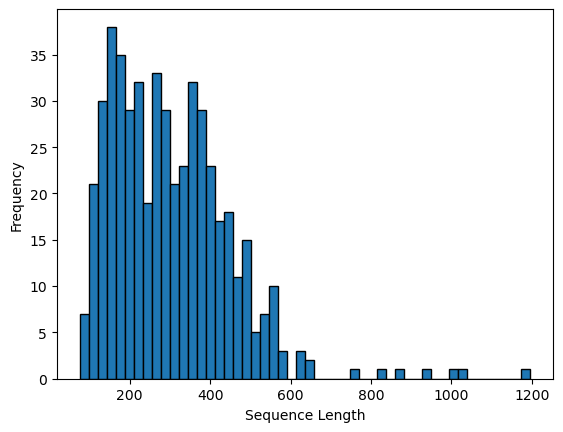

In [14]:
import matplotlib.pyplot as plt

### Haga el gráfico del histograma
# Obtener la columna 'texto' del dataframe
columna_texto = train_df['lyrics']

# Iterar sobre cada registro y contar las palabras
conteo_palabras = [len(registro.split()) for registro in columna_texto]


plt.hist(conteo_palabras, bins=50, edgecolor='black')

###
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

Teniendo en cuenta el historgrama anterior, determine el tamaño de la secuencia máxima para el modelo, en `max_length`. 

In [15]:
max_length = 400

# Tokenización de Secuencias para Entrenamiento 

Con lo anterior, ya se tiene definida la forma en que se tokenizará el texto para el modelo. Utilice el método `fit_on_texts` para transformar los datos de train, test y validación. 

El Tokenizador  ya conoce el vocabulario que se va a utilizar en el diccionario. Por lo anterior, es necesario transformar las canciones en las secuencias de texto correspondientes. Para esto, se utilizará el método [`.texts_to_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences) sobre los datos de train, test y validación. 


In [16]:
X_train = tokenizer.texts_to_sequences(train_df['lyrics'])
X_val = tokenizer.texts_to_sequences(val_df['lyrics'])
X_test = tokenizer.texts_to_sequences(test_df['lyrics'])


Anteriormente se definió un largo máximo para la secuencia (la cantidad de palabras en las canciones). Esta información se encuentra en `max_length`. Como es posible tener canciones con pocas palabras (menos de `max_length`) o muy largas (más de `max_length`) es necesario utilizar una técnica que se llama `padding`, con el objetivo de estandarizar el tamaño del input que procesará la red neuronal. 

De esta formas, canciones con diferente tamaño tendrán la misma longitud. 

Un ejemplo de lo anterior es, 


| Before padding | After padding (with maxlen=6) |
| :--- | :--- |
| `["qué", "fue", "bebé"]` | `[0, 0, 0, "qué", "fue", "bebé"]` |
| `["porque", "la", "noche", "de", "anoche", "fue"]` | `["porque", "la", "noche", "de", "anoche", "fue"]` |
| `["altanera", "preciosa", "y", "orgullosa", "no", "permite", "la", "quieran", "consolar"]` | `["altanera", "preciosa", "y", "orgullosa", "no", "permite"]` |


Utilice el método [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) para garantizar que todas las secuencias de texto tengan el mismo tamaño, siendo este `max_length`. 


In [17]:
###
X_train = None
X_val = None
X_test = None
###

A continuación se puede observar un ejemplo de la tokenización y el padding. 

In [18]:
tokenized_bichota =  tokenizer.texts_to_sequences(["baby que mas hace rato que no sé anda de ti"])

In [19]:
#tokenized_bichota

In [20]:
tokenized_bichota = pad_sequences(tokenized_bichota, maxlen=20) # Ejemplo con 20 de padding. 

In [21]:
## Interpreta una secuencia de números en los tokens
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

# Decodifica el texto
decoded_text = [reverse_word_index.get(i, '?') for i in tokenized_bichota[0]]

# Generación de Frase
original_text = ' '.join(decoded_text)
print(original_text)


? ? ? ? ? ? ? ? ? ? ? ? baby que mas hace que no de ti


A continuación se acomoda el target del modelo por la categoría.

In [22]:
genre_index = {genre: i for i, genre in enumerate(genres)}

y_train = train_df['genre'].apply(lambda x: genre_index[x]).values
y_val = val_df['genre'].apply(lambda x: genre_index[x]).values
y_test = test_df['genre'].apply(lambda x: genre_index[x]).values


In [23]:
genre_index

{'reggaeton': 0, 'ranchera': 1, 'salsa': 2}

In [24]:
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch):
    initial_lr = 0.01#0.001
    drop_rate = 0.5
    epochs_drop = 10
    lr = initial_lr * drop_rate ** (epoch // epochs_drop)
    return lr

lr_scheduler = LearningRateScheduler(step_decay)


In [25]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

A continuación defina su modelo de Red Neuronal. Se recomienda utilizar una Embedding Layer ([`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) para generar representaciones vectoriales de cada uno de los `tokens` presentes en el vocabulario del modelo. 

Adicionalmente, utilice celdas [`tf.keras.kayers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) para modelar la naturaleza secuencial de los datos. 

Puede utilizar también celdas [`tf.keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) para permitir generar conexiones en la dirección opuesta a la secuencia original. 

Incluya dropout, regularización y Early Stopping si considera necesario. 

In [26]:
###
LSTM_model = Sequential([
    
    Embedding(max_words, 128, input_length=max_length), # No elimine. Puede cambiar 128 por otra dimensión
    None, 
])

###



TypeError: The added layer must be an instance of class Layer. Received: layer=None of type <class 'NoneType'>.

Se va a definir un learning Rate Schedule en el que las tasa de aprendizaje disminuye conforme avanza el entrenamiento del modelo. 

In [ ]:


def scheduler(epoch, lr):
    min_lr = 1e-6  # Mínimo Learning Rate
    if epoch % 10 == 0 and epoch != 0:
        new_lr = lr * 0.1
        return max(new_lr, min_lr)  # Devuelva la learning rate
    else:
        return lr


lr_scheduler = LearningRateScheduler(scheduler, verbose=0)


initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

Compile el modelo. Recuerde definir función de pérdida y las métricas de validación adecuadas para este problema.

In [ ]:
###
LSTM_model.compile(None)

###



A continuación, cree el CallBack para el Early Stopping del Modelo

In [ ]:
###
early_stopping = EarlyStopping(None)
###

Y se crea un callback de TensorFlow para guardar los valores de la embedding layer.

In [ ]:
log_dir = './logs'
tensorboard_callback = TensorBoard(log_dir=log_dir, 
                                   embeddings_freq=1, 
                                   embeddings_layer_names=['embedding'], 
                                   embeddings_metadata='metadata.tsv')

A continuación entre el modelo... 

In [ ]:

history = LSTM_model.fit(X_train, y_train, 
                                  validation_data=(X_val, y_val), 
                                  epochs=100, 
                                  batch_size=64, 
                                  callbacks=[early_stopping, lr_scheduler, tensorboard_callback ])

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

A continuación se realiza la evaluación del modelo en test. 

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming lstm_advanced_model is the model you want to use
# Make predictions on the test set
predictions = LSTM_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Define your genre_index dictionary

# Sort the dictionary by values and extract the keys (labels)
labels = [k for k, v in sorted(genre_index.items(), key=lambda item: item[1])]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax)
plt.show()


¿Qué puede concluir del desempeño del modelo?